# Result explorer

Browse training runs stored in `results/`.
- Load metrics/params into tidy DataFrames.
- Rank classification runs by accuracy and regression runs by R².
- Drill into a run to view config details, learning curves, and (for classification) the confusion matrix.


In [1]:
from pathlib import Path
import json

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid")
pd.set_option("display.max_columns", 50)

NOTEBOOK_DIR = Path(__file__).resolve().parent if "__file__" in globals() else Path.cwd().resolve()

def find_project_root(start: Path) -> Path:
    for candidate in [start, *start.parents]:
        if (candidate / "pyproject.toml").exists():
            return candidate
    return start

PROJECT_ROOT = find_project_root(NOTEBOOK_DIR)
RESULTS_ROOT = PROJECT_ROOT / "results"

print(f"Notebook dir: {NOTEBOOK_DIR}")
print(f"Project root: {PROJECT_ROOT}")
print(f"Results root: {RESULTS_ROOT}")
if not RESULTS_ROOT.exists():
    raise FileNotFoundError(f"Expected results at {RESULTS_ROOT}")


Notebook dir: /home/ojs/Workspace/Projects/Neuro/Neuro1-3/EEG-Emo-Rec/src/result_explorer
Project root: /home/ojs/Workspace/Projects/Neuro/Neuro1-3/EEG-Emo-Rec
Results root: /home/ojs/Workspace/Projects/Neuro/Neuro1-3/EEG-Emo-Rec/results


In [2]:
def read_json(path: Path) -> dict:
    with path.open() as f:
        return json.load(f)


def iter_runs(kind: str):
    run_root = RESULTS_ROOT / kind
    if not run_root.exists():
        return
    for run_dir in sorted(run_root.iterdir()):
        if not run_dir.is_dir():
            continue
        metrics_path = run_dir / "metrics.json"
        params_path = run_dir / "params.json"
        if metrics_path.exists() and params_path.exists():
            yield run_dir.name, params_path, metrics_path


def to_summary_row(kind: str, run_id: str, params: dict, metrics: dict) -> dict:
    training_option = params["training_option"]
    data_opt = training_option["training_data_option"]
    feature_opt = data_opt["feature_extraction_option"]
    record = {
        "run": run_id,
        "target": data_opt.get("target"),
        "target_kind": data_opt.get("target_kind"),
        "model": params["model_option"]["name"],
        "training_method": training_option["training_method_option"]["name"],
        "feature": feature_opt["feature_option"]["name"],
        "channels": ", ".join(feature_opt["channel_pick_option"]["channel_pick"]),
        "preprocessing": feature_opt["preprocessing_option"]["name"],
        "segmentation": feature_opt["segmentation_option"]["name"],
        "feature_scaler": data_opt.get("feature_scaler"),
        "use_size": data_opt.get("use_size"),
        "test_size": data_opt.get("test_size"),
        "random_seed": data_opt.get("random_seed"),
        "best_epoch": metrics.get("best_epoch"),
        "best_val_loss": metrics.get("best_val_loss"),
        "total_seconds": metrics.get("total_seconds"),
        "params_hash": metrics.get("params_hash"),
    }
    if kind == "classification":
        test = (metrics.get("test_metrics") or {}).get("classification", {})
        train = (metrics.get("train_metrics") or {}).get("classification", {})
        record.update(
            {
                "test_accuracy": test.get("accuracy"),
                "test_bal_accuracy": test.get("balanced_accuracy"),
                "test_f1_macro": test.get("f1_macro"),
                "test_f1_weighted": test.get("f1_weighted"),
                "train_accuracy": train.get("accuracy"),
                "train_bal_accuracy": train.get("balanced_accuracy"),
            }
        )
    else:
        test = (metrics.get("test_metrics") or {}).get("regression", {})
        train = (metrics.get("train_metrics") or {}).get("regression", {})
        record.update(
            {
                "test_mae": test.get("mae"),
                "test_rmse": test.get("rmse"),
                "test_r2": test.get("r2"),
                "test_explained_var": test.get("explained_variance"),
                "train_mae": train.get("mae"),
                "train_r2": train.get("r2"),
            }
        )
    return record


def build_summary(kind: str) -> pd.DataFrame:
    rows = []
    for run_id, params_path, metrics_path in iter_runs(kind):
        rows.append(
            to_summary_row(
                kind=kind,
                run_id=run_id,
                params=read_json(params_path),
                metrics=read_json(metrics_path),
            )
        )
    df = pd.DataFrame(rows)
    if df.empty:
        return df
    if kind == "classification":
        return df.sort_values(["test_accuracy", "test_bal_accuracy"], ascending=False)
    return df.sort_values(["test_r2", "test_rmse"], ascending=[False, True])


def load_run_artifacts(kind: str, run_id: str):
    run_dir = RESULTS_ROOT / kind / run_id
    metrics = read_json(run_dir / "metrics.json")
    params = read_json(run_dir / "params.json")
    return run_dir, params, metrics


def describe_run(params: dict) -> pd.Series:
    training_option = params["training_option"]
    data_opt = training_option["training_data_option"]
    feature_opt = data_opt["feature_extraction_option"]
    return pd.Series(
        {
            "target": data_opt.get("target"),
            "target_kind": data_opt.get("target_kind"),
            "model": params["model_option"]["name"],
            "backend": params["model_option"].get("backend"),
            "training_method": training_option["training_method_option"]["name"],
            "preprocessing": feature_opt["preprocessing_option"]["name"],
            "feature": feature_opt["feature_option"]["name"],
            "channels": ", ".join(feature_opt["channel_pick_option"]["channel_pick"]),
            "segmentation": feature_opt["segmentation_option"]["name"],
            "feature_scaler": data_opt.get("feature_scaler"),
            "use_size": data_opt.get("use_size"),
            "test_size": data_opt.get("test_size"),
            "random_seed": data_opt.get("random_seed"),
        }
    )


In [3]:
def plot_learning_curves(metrics: dict):
    epochs = pd.DataFrame(metrics.get("epochs", []))
    if epochs.empty:
        print("No epoch-level metrics recorded.")
        return
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    has_loss = {"epoch", "train_loss", "val_loss"}.issubset(epochs.columns)
    if has_loss:
        axes[0].plot(epochs["epoch"], epochs["train_loss"], label="train")
        axes[0].plot(epochs["epoch"], epochs["val_loss"], label="val")
        axes[0].set_title("Loss")
        axes[0].set_xlabel("epoch")
        axes[0].legend()
    else:
        axes[0].axis("off")

    mae_cols = [col for col in ["train_mae", "val_mae"] if col in epochs]
    has_epoch = "epoch" in epochs
    if mae_cols and has_epoch:
        for col, label in zip(mae_cols, ["train", "val"]):
            axes[1].plot(epochs["epoch"], epochs[col], label=label)
        axes[1].set_title("MAE")
        axes[1].set_xlabel("epoch")
        axes[1].legend()
    else:
        axes[1].axis("off")
    fig.tight_layout()


def plot_confusion_matrix(metrics: dict):
    cls = (metrics.get("test_metrics") or {}).get("classification")
    if not cls or "confusion_matrix" not in cls:
        print("No confusion matrix recorded.")
        return
    labels = cls.get("labels") or range(len(cls["confusion_matrix"]))
    cm = pd.DataFrame(cls["confusion_matrix"], index=labels, columns=labels)
    fig, ax = plt.subplots(figsize=(6, 5))
    sns.heatmap(cm, annot=False, cmap="viridis", ax=ax, cbar=True)
    ax.set_xlabel("Predicted label")
    ax.set_ylabel("True label")
    ax.set_title("Test confusion matrix")
    fig.tight_layout()


In [4]:
classification_runs = build_summary("classification")
regression_runs = build_summary("regression")

print("Classification runs (head):")
if classification_runs.empty:
    print("No classification runs found.")
else:
    display(classification_runs.head(10))

print("Regression runs (head):")
if regression_runs.empty:
    print("No regression runs found.")
else:
    display(regression_runs.head(10))


Classification runs (head):


,run,target,target_kind,model,training_method,feature,channels,preprocessing,segmentation,feature_scaler,use_size,test_size,random_seed,best_epoch,best_val_loss,total_seconds,params_hash,test_accuracy,test_bal_accuracy,test_f1_macro,test_f1_weighted,train_accuracy,train_bal_accuracy
3,20251127_103624_187068,valence,classification,cnn1d_n1_classification,adam_classification,psd,"Fp1, AF3, F3, F7, FC5, FC1, C3, T7, CP5, CP1, ...",clean,w2.00_s0.25,minmax,1.0,0.2,42,30,1.250679,2133.423786,fb609adedc6aae638988bb917b1d93b4f04cd09457fd8d...,0.553246,0.559774,0.555485,0.552615,0.637503,0.648678
2,20251126_123829_815804,valence,classification,cnn1d_n1_classification,adam_classification,psd,"Fp1, Fp2, F3, F4, P3, P4, T7, T8",clean,w2.00_s0.25,minmax,1.0,0.2,42,28,1.570142,546.985713,95c749eb03911754ef600d485d7b41149db12020d8bdac...,0.416024,0.415052,0.413545,0.414283,0.464068,0.466733
1,20251126_122104_045132,valence,classification,cnn1d_n1_classification,adam_classification,psd,"Fp1, Fp2, F3, F4, P3, P4",clean,w2.00_s0.25,minmax,1.0,0.2,42,30,1.739873,430.140968,91dd81a9fbb14c7eae5f271e1389554625d07aa53e23ed...,0.334244,0.313272,0.318217,0.324840,0.378810,0.362048
4,20251127_120256_074427,valence,classification,cnn1d_n1_classification,adam_classification,de,"F3, F4, P3, P4",clean,w2.00_s0.25,minmax,1.0,0.2,42,30,1.763635,368.414866,c2c53e5d8a30162fbd988821d55fb8fbd11ae7f2212c96...,0.332635,0.307483,0.310261,0.319199,0.376811,0.352050
10,20251201_091434_745457,valence,classification,cnn1d_n1_classification,adam_classification,de,"F3, F4, P3, P4",clean,w2.00_s0.25,standard,1.0,0.2,42,30,1.779570,380.713468,35638d069263ce989a8c3d6dddffd5f4d0a8bb63412880...,0.329215,0.305522,0.307323,0.316925,0.382980,0.363150
0,20251126_102637_985634,valence,classification,cnn1d_n1_classification,adam_classification,psd,"F3, F4, P3, P4",clean,w2.00_s0.25,minmax,1.0,0.2,42,28,1.834847,347.668446,6090f8f85d1a5dd0575dfe1f14616b0a1b11517a09f912...,0.297847,0.264954,0.261868,0.275360,0.333314,0.301266
5,20251127_162430_439057,valence,classification,cnn1d_n1_classification,adam_classification,psd,"F3, F4, P3, P4",clean,w2.00_s0.25,standard,1.0,0.2,42,30,1.846084,338.756337,0617dcfea3affe14ee8abbc10bd55663219f1b851140ac...,0.297076,0.262441,0.257582,0.270489,0.342497,0.310363
7,20251127_165832_571136,valence,classification,cnn1d_n1_classification,adam_classification,deasm,"F3, F4, P3, P4",clean,w2.00_s0.25,minmax,1.0,0.2,42,30,2.029447,255.843477,1b9bb2992ad672e99425375987a8cdee7bbd0577bfb3a3...,0.219991,0.157007,0.142769,0.175060,0.241483,0.176351
6,20251127_165406_534626,valence,classification,cnn1d_n1_classification,adam_classification,deasm,"F3, F4, P3, P4",clean,w2.00_s0.25,standard,1.0,0.2,42,25,2.034698,262.956988,cb51b9cf7b6b037c71012b6d40bb31ed23bf99de0d55b7...,0.219052,0.161384,0.148558,0.179926,0.253722,0.193411
9,20251201_090836_300455,valence,classification,cnn1d_n1_classification,adam_classification,dasm,"F3, F4, P3, P4",clean,w2.00_s0.25,minmax,1.0,0.2,42,30,2.052891,264.929060,962721b512081b911ad9f35190d084f26115bf2aed382d...,0.211390,0.141628,0.116120,0.150216,0.221805,0.150296


Regression runs (head):


,run,target,target_kind,model,training_method,feature,channels,preprocessing,segmentation,feature_scaler,use_size,test_size,random_seed,best_epoch,best_val_loss,total_seconds,params_hash,test_mae,test_rmse,test_r2,test_explained_var,train_mae,train_r2
5,20251126_123436_295004,valence,regression,cnn1d_n1_regression,adam_regression,psd,"Fp1, Fp2, F3, F4, P3, P4, T7, T8",clean,w2.00_s0.25,minmax,1.0,0.2,42,10,3.568438,225.182074,31e484621c3f00033ed864f2d91628769bbd675256c28d...,1.549605,1.889031,0.217445,0.221990,1.505111,0.256947
9,20251127_121516_188311,valence,regression,cnn1d_n1_regression,adam_regression,de,"Fp1, Fp2, F3, F4, P3, P4",clean,w2.00_s0.25,minmax,1.0,0.2,42,10,3.764285,217.712083,86b99bf734a04a9828118311e18de314aa0bf64076c856...,1.610981,1.940177,0.174496,0.175569,1.582184,0.201165
4,20251126_103723_163514,valence,regression,cnn1d_n1_regression,adam_regression,psd,"Fp1, Fp2, F3, F4, P3, P4",clean,w2.00_s0.25,minmax,1.0,0.2,42,10,3.906190,210.422234,8244df846aa98f2a24bfff4626d4a86baca9935706bc6c...,1.646935,1.976408,0.143377,0.143524,1.622470,0.164295
8,20251127_115944_699529,valence,regression,cnn1d_n1_regression,adam_regression,de,"F3, F4, P3, P4",clean,w2.00_s0.25,minmax,1.0,0.2,42,10,4.021484,184.938204,10432429d91cd91a95f044dcf7a8769e05d2905b007abf...,1.677910,2.005364,0.118093,0.118149,1.653659,0.139113
0,20251125_204447_081445,valence,regression,cnn1d_n1_regression,adam_regression,psd,"F3, F4, P3, P4",clean,2.00s_0.25s,minmax,1.0,0.2,42,10,4.140137,168.488841,d06df455dcd2446fbe94f9c4b0fc8377968c7942a8ddd0...,1.706605,2.034733,0.092072,0.092310,1.687017,0.107011
1,20251125_212400_760036,valence,regression,cnn1d_n1_regression,adam_regression,psd,"F3, F4, P3, P4",clean,2.00s_0.25s,minmax,1.0,0.2,42,10,4.140137,166.493050,a5121059c40e5c247364255e79ea1a12be822278e5aa1a...,1.706605,2.034733,0.092072,0.092310,1.687017,0.107011
2,20251125_213159_938124,valence,regression,cnn1d_n1_regression,adam_regression,psd,"F3, F4, P3, P4",clean,w2.00_s0.25,minmax,1.0,0.2,42,10,4.140137,171.537364,2e93ceb21e5db0e7ec8a784030a593d6d3abcd7e535a00...,1.706605,2.034733,0.092072,0.092310,1.687017,0.107011
3,20251126_094256_934667,valence,regression,cnn1d_n1_regression,adam_regression,psd,"F3, F4, P3, P4",clean,w2.00_s0.25,minmax,1.0,0.2,42,10,4.140137,174.729508,95ff87552b074a66d23118661603925ccbe2f81aef1484...,1.706605,2.034733,0.092072,0.092310,1.687017,0.107011
7,20251127_103249_593157,valence,regression,cnn1d_n1_regression,adam_regression,psd,"F3, F4, P3, P4",clean,w2.00_s0.25,minmax,1.0,0.2,42,10,4.140137,162.482715,b58173c0b4c77ee5215d69e124b4ffee49f2599290defa...,1.706605,2.034733,0.092072,0.092310,1.687017,0.107011
6,20251126_164841_806366,valence,regression,cnn1d_n1_regression,adam_regression,psd,"Fp1, AF3, F3, F7, FC5, FC1, C3, T7, CP5, CP1, ...",clean,w2.00_s0.25,minmax,1.0,0.2,42,10,4.161345,681.238304,1906446adeeda3da62ad69d07016a45bcdfe5f44064b72...,1.710296,2.039937,0.087421,0.089163,1.700760,0.090556


### Inspect a specific run
Set `kind` and `run_id` to explore a run in detail.


In [5]:
kind = "classification"  # or "regression"
default_df = classification_runs if kind == "classification" else regression_runs
run_id = default_df.iloc[0]["run"] if not default_df.empty else ""
print(f"Selected run: {run_id}")


Selected run: 20251127_103624_187068


In [6]:
if run_id:
    run_dir, params, metrics = load_run_artifacts(kind, run_id)
    print(f"Inspecting run at {run_dir}")
    display(describe_run(params).to_frame("value"))
else:
    print("Set run_id to explore a run.")


Inspecting run at /home/ojs/Workspace/Projects/Neuro/Neuro1-3/EEG-Emo-Rec/results/classification/20251127_103624_187068


,value
target,valence
target_kind,classification
model,cnn1d_n1_classification
backend,torch
training_method,adam_classification
preprocessing,clean
feature,psd
channels,"Fp1, AF3, F3, F7, FC5, FC1, C3, T7, CP5, CP1, ..."
segmentation,w2.00_s0.25
feature_scaler,minmax


In [7]:
if run_id:
    if kind == "classification":
        test_metrics = metrics["test_metrics"]["classification"]
        train_metrics = metrics["train_metrics"]["classification"]
    else:
        test_metrics = metrics["test_metrics"]["regression"]
        train_metrics = metrics["train_metrics"]["regression"]
    display(pd.DataFrame({"train": train_metrics, "test": test_metrics}))
else:
    print("Set run_id to explore a run.")


,train,test
labels,"[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0]","[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0]"
accuracy,0.637503,0.553246
balanced_accuracy,0.648678,0.559774
precision_macro,0.637963,0.553713
precision_micro,0.637503,0.553246
precision_weighted,0.638542,0.554278
recall_macro,0.648678,0.559774
recall_micro,0.637503,0.553246
recall_weighted,0.637503,0.553246
f1_macro,0.641775,0.555485


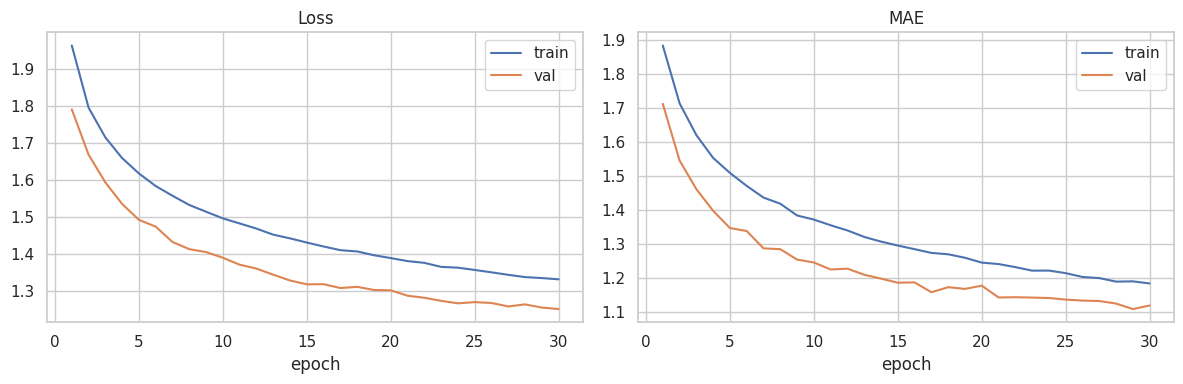

In [8]:
if run_id:
    plot_learning_curves(metrics)
else:
    print("Set run_id to explore a run.")


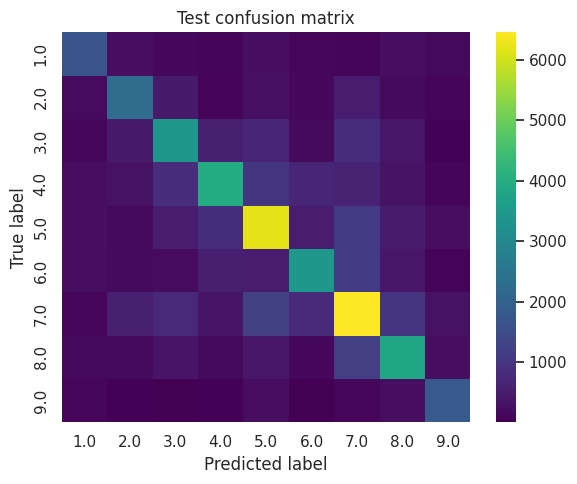

In [9]:
if run_id and kind == "classification":
    plot_confusion_matrix(metrics)
elif not run_id:
    print("Set run_id to explore a run.")
